In [ ]:
!nvidia-smi

!pip install torch torchvision tqdm


Sun Nov 30 07:27:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
files.upload()

Saving processed_images.zip to processed_images.zip
Buffered data was truncated after reaching the output size limit.

In [12]:
from google.colab import files
files.upload()

Saving density_maps.zip to density_maps.zip


In [13]:
!unzip processed_images.zip -d processed_images
!unzip density_maps.zip -d density_maps

Archive:  processed_images.zip
   creating: processed_images/processed_images/
  inflating: processed_images/processed_images/IMG_1.jpg  
  inflating: processed_images/processed_images/IMG_10.jpg  
  inflating: processed_images/processed_images/IMG_100.jpg  
  inflating: processed_images/processed_images/IMG_101.jpg  
  inflating: processed_images/processed_images/IMG_102.jpg  
  inflating: processed_images/processed_images/IMG_103.jpg  
  inflating: processed_images/processed_images/IMG_104.jpg  
  inflating: processed_images/processed_images/IMG_105.jpg  
  inflating: processed_images/processed_images/IMG_106.jpg  
  inflating: processed_images/processed_images/IMG_107.jpg  
  inflating: processed_images/processed_images/IMG_108.jpg  
  inflating: processed_images/processed_images/IMG_109.jpg  
  inflating: processed_images/processed_images/IMG_11.jpg  
  inflating: processed_images/processed_images/IMG_110.jpg  
  inflating: processed_images/processed_images/IMG_111.jpg  
  inflatin

In [23]:
IMG_DIR = "/content/drive/MyDrive/crowd_project/processed_images/processed_images"
DENSITY_DIR = "/content/drive/MyDrive/crowd_project/density_maps/density_maps"

Transform Pipeline

In [24]:
transform = T.Compose([
    T.ToTensor(),  # Convert image to PyTorch tensor
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

CrowdDataset Class

In [25]:
class CrowdDataset(Dataset):
    def __init__(self, img_dir, density_dir, file_list, transform=None):
        self.img_dir = img_dir
        self.density_dir = density_dir
        self.files = file_list
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]

        img = cv2.imread(os.path.join(self.img_dir, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(img)

        den = np.load(os.path.join(self.density_dir, img_name.replace(".jpg", ".npy")))
        den = cv2.resize(den, (den.shape[1]//8, den.shape[0]//8))
        den = den * 64

        den_tensor = torch.tensor(den, dtype=torch.float32).unsqueeze(0)

        return img, den_tensor


CSRNet Model Definition

In [26]:
cfg = {
    'frontend': [64, 64, 'M',
                 128, 128, 'M',
                 256, 256, 256, 'M',
                 512, 512, 512],
    'backend': [512, 512, 512, 256, 128, 64]
}

def make_layers(cfg_list, in_channels=3, dilation=False):
    layers = []
    for v in cfg_list:
        if v == 'M':
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        else:
            if dilation:
                conv2d = nn.Conv2d(in_channels, v, 3, padding=2, dilation=2)
            else:
                conv2d = nn.Conv2d(in_channels, v, 3, padding=1)
            layers += [conv2d, nn.ReLU(True)]
            in_channels = v
    return nn.Sequential(*layers)

class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()
        self.frontend = make_layers(cfg['frontend'], in_channels=3, dilation=False)
        self.backend = make_layers(cfg['backend'], in_channels=512, dilation=True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x


Train / Validation Split + DataLoaders

In [27]:
image_files = [f for f in os.listdir(IMG_DIR) if f.endswith(".jpg")]
train_files, val_files = train_test_split(image_files, test_size=0.17, random_state=42)

train_dataset = CrowdDataset(IMG_DIR, DENSITY_DIR, train_files, transform)
val_dataset = CrowdDataset(IMG_DIR, DENSITY_DIR, val_files, transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

print("Train:", len(train_dataset), "Validation:", len(val_dataset))

Train: 248 Validation: 52


Initialize Model, Loss, Optimizer

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

model = CSRNet().to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

Running on: cuda


Training Loop

In [29]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for imgs, dens in tqdm(train_loader):
        imgs = imgs.to(device)
        dens = dens.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, dens)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss/len(train_loader):.4f}")


100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


Epoch [1/10] - Train Loss: 0.1300


100%|██████████| 62/62 [00:35<00:00,  1.76it/s]


Epoch [2/10] - Train Loss: 0.1194


100%|██████████| 62/62 [00:37<00:00,  1.66it/s]


Epoch [3/10] - Train Loss: 0.1164


100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


Epoch [4/10] - Train Loss: 0.1076


100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Epoch [5/10] - Train Loss: 0.0988


100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Epoch [6/10] - Train Loss: 0.0940


100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Epoch [7/10] - Train Loss: 0.0909


100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Epoch [8/10] - Train Loss: 0.0924


100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


Epoch [9/10] - Train Loss: 0.0901


100%|██████████| 62/62 [00:37<00:00,  1.64it/s]

Epoch [10/10] - Train Loss: 0.0897


Prediction Visualization

GT Count: 753.26746
Pred Count: 311.83005


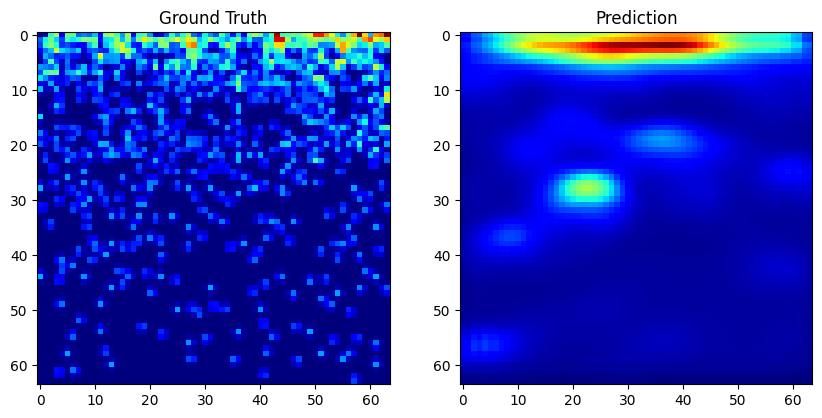

In [30]:
model.eval()
with torch.no_grad():
    imgs, dens = next(iter(val_loader))
    imgs = imgs.to(device)
    preds = model(imgs)

    gt = dens[0].cpu().numpy().squeeze()
    pr = preds[0].cpu().numpy().squeeze()

    print("GT Count:", gt.sum())
    print("Pred Count:", pr.sum())

    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    plt.imshow(gt, cmap='jet')
    plt.title("Ground Truth")

    plt.subplot(1,2,2)
    plt.imshow(pr, cmap='jet')
    plt.title("Prediction")
    plt.show()


In [31]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for imgs, dens in tqdm(train_loader):
        imgs = imgs.to(device)
        dens = dens.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, dens)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss/len(train_loader):.4f}")


100%|██████████| 62/62 [00:39<00:00,  1.58it/s]


Epoch [1/50] - Train Loss: 0.0896


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [2/50] - Train Loss: 0.0861


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [3/50] - Train Loss: 0.0861


100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


Epoch [4/50] - Train Loss: 0.0830


100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Epoch [5/50] - Train Loss: 0.0860


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [6/50] - Train Loss: 0.0827


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [7/50] - Train Loss: 0.0834


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [8/50] - Train Loss: 0.0885


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [9/50] - Train Loss: 0.0820


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [10/50] - Train Loss: 0.0792


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [11/50] - Train Loss: 0.0788


100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


Epoch [12/50] - Train Loss: 0.0796


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [13/50] - Train Loss: 0.0767


100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


Epoch [14/50] - Train Loss: 0.0751


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [15/50] - Train Loss: 0.0755


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [16/50] - Train Loss: 0.0736


100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


Epoch [17/50] - Train Loss: 0.0713


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [18/50] - Train Loss: 0.0721


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [19/50] - Train Loss: 0.0735


100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


Epoch [20/50] - Train Loss: 0.0729


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [21/50] - Train Loss: 0.0697


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [22/50] - Train Loss: 0.0674


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [23/50] - Train Loss: 0.0739


100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


Epoch [24/50] - Train Loss: 0.0679


100%|██████████| 62/62 [00:38<00:00,  1.61it/s]


Epoch [25/50] - Train Loss: 0.0701


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [26/50] - Train Loss: 0.0660


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [27/50] - Train Loss: 0.0657


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [28/50] - Train Loss: 0.0699


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [29/50] - Train Loss: 0.0645


100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Epoch [30/50] - Train Loss: 0.0655


100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


Epoch [31/50] - Train Loss: 0.0644


100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


Epoch [32/50] - Train Loss: 0.0660


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [33/50] - Train Loss: 0.0632


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [34/50] - Train Loss: 0.0646


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [35/50] - Train Loss: 0.0657


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [36/50] - Train Loss: 0.0651


100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


Epoch [37/50] - Train Loss: 0.0659


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [38/50] - Train Loss: 0.0627


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [39/50] - Train Loss: 0.0649


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [40/50] - Train Loss: 0.0608


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [41/50] - Train Loss: 0.0620


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [42/50] - Train Loss: 0.0599


100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


Epoch [43/50] - Train Loss: 0.0647


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [44/50] - Train Loss: 0.0621


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [45/50] - Train Loss: 0.0588


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [46/50] - Train Loss: 0.0592


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [47/50] - Train Loss: 0.0611


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [48/50] - Train Loss: 0.0635


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [49/50] - Train Loss: 0.0605


100%|██████████| 62/62 [00:38<00:00,  1.61it/s]

Epoch [50/50] - Train Loss: 0.0580


GT Count: 753.26746
Pred Count: 376.49207


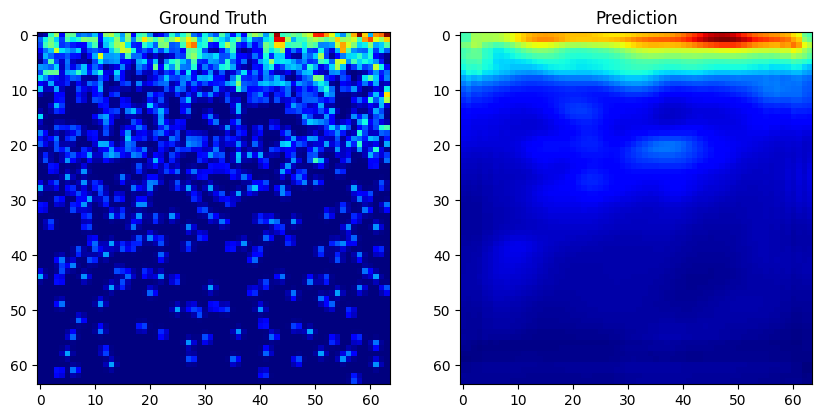

In [32]:
model.eval()
with torch.no_grad():
    imgs, dens = next(iter(val_loader))
    imgs = imgs.to(device)
    preds = model(imgs)

    gt = dens[0].cpu().numpy().squeeze()
    pr = preds[0].cpu().numpy().squeeze()

    print("GT Count:", gt.sum())
    print("Pred Count:", pr.sum())

    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    plt.imshow(gt, cmap='jet')
    plt.title("Ground Truth")

    plt.subplot(1,2,2)
    plt.imshow(pr, cmap='jet')
    plt.title("Prediction")
    plt.show()


In [33]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for imgs, dens in tqdm(train_loader):
        imgs = imgs.to(device)
        dens = dens.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, dens)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss/len(train_loader):.4f}")

100%|██████████| 62/62 [00:38<00:00,  1.59it/s]


Epoch [1/100] - Train Loss: 0.0585


100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


Epoch [2/100] - Train Loss: 0.0627


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [3/100] - Train Loss: 0.0726


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [4/100] - Train Loss: 0.0596


100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Epoch [5/100] - Train Loss: 0.0598


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [6/100] - Train Loss: 0.0605


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [7/100] - Train Loss: 0.0610


100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Epoch [8/100] - Train Loss: 0.0587


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [9/100] - Train Loss: 0.0558


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [10/100] - Train Loss: 0.0579


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [11/100] - Train Loss: 0.0553


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [12/100] - Train Loss: 0.0575


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [13/100] - Train Loss: 0.0544


100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Epoch [14/100] - Train Loss: 0.0571


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [15/100] - Train Loss: 0.0565


100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


Epoch [16/100] - Train Loss: 0.0602


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [17/100] - Train Loss: 0.0582


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [18/100] - Train Loss: 0.0593


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [19/100] - Train Loss: 0.0557


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [20/100] - Train Loss: 0.0565


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [21/100] - Train Loss: 0.0529


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [22/100] - Train Loss: 0.0537


100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Epoch [23/100] - Train Loss: 0.0542


100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Epoch [24/100] - Train Loss: 0.0564


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [25/100] - Train Loss: 0.0551


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [26/100] - Train Loss: 0.0545


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [27/100] - Train Loss: 0.0533


100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Epoch [28/100] - Train Loss: 0.0529


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [29/100] - Train Loss: 0.0512


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [30/100] - Train Loss: 0.0549


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [31/100] - Train Loss: 0.0521


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [32/100] - Train Loss: 0.0534


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [33/100] - Train Loss: 0.0499


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [34/100] - Train Loss: 0.0525


100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


Epoch [35/100] - Train Loss: 0.0495


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [36/100] - Train Loss: 0.0500


100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Epoch [37/100] - Train Loss: 0.0536


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [38/100] - Train Loss: 0.0533


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [39/100] - Train Loss: 0.0547


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [40/100] - Train Loss: 0.0515


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [41/100] - Train Loss: 0.0498


100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


Epoch [42/100] - Train Loss: 0.0486


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [43/100] - Train Loss: 0.0564


100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Epoch [44/100] - Train Loss: 0.0554


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [45/100] - Train Loss: 0.0505


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [46/100] - Train Loss: 0.0487


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [47/100] - Train Loss: 0.0506


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [48/100] - Train Loss: 0.0498


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [49/100] - Train Loss: 0.0556


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [50/100] - Train Loss: 0.0495


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [51/100] - Train Loss: 0.0497


100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Epoch [52/100] - Train Loss: 0.0511


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [53/100] - Train Loss: 0.0484


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [54/100] - Train Loss: 0.0480


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [55/100] - Train Loss: 0.0480


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [56/100] - Train Loss: 0.0492


100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Epoch [57/100] - Train Loss: 0.0459


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [58/100] - Train Loss: 0.0463


100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


Epoch [59/100] - Train Loss: 0.0470


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [60/100] - Train Loss: 0.0446


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [61/100] - Train Loss: 0.0456


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [62/100] - Train Loss: 0.0461


100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Epoch [63/100] - Train Loss: 0.0482


100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Epoch [64/100] - Train Loss: 0.0472


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [65/100] - Train Loss: 0.0451


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [66/100] - Train Loss: 0.0484


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [67/100] - Train Loss: 0.0478


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [68/100] - Train Loss: 0.0444


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [69/100] - Train Loss: 0.0446


100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Epoch [70/100] - Train Loss: 0.0453


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [71/100] - Train Loss: 0.0465


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [72/100] - Train Loss: 0.0435


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [73/100] - Train Loss: 0.0455


100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


Epoch [74/100] - Train Loss: 0.0452


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [75/100] - Train Loss: 0.0454


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [76/100] - Train Loss: 0.0433


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [77/100] - Train Loss: 0.0429


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [78/100] - Train Loss: 0.0436


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [79/100] - Train Loss: 0.0439


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [80/100] - Train Loss: 0.0433


100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


Epoch [81/100] - Train Loss: 0.0436


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [82/100] - Train Loss: 0.0428


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [83/100] - Train Loss: 0.0455


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [84/100] - Train Loss: 0.0521


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [85/100] - Train Loss: 0.0425


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [86/100] - Train Loss: 0.0434


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [87/100] - Train Loss: 0.0426


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [88/100] - Train Loss: 0.0441


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [89/100] - Train Loss: 0.0461


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [90/100] - Train Loss: 0.0413


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [91/100] - Train Loss: 0.0440


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [92/100] - Train Loss: 0.0450


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [93/100] - Train Loss: 0.0413


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [94/100] - Train Loss: 0.0416


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [95/100] - Train Loss: 0.0428


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [96/100] - Train Loss: 0.0424


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [97/100] - Train Loss: 0.0425


100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Epoch [98/100] - Train Loss: 0.0396


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Epoch [99/100] - Train Loss: 0.0401


100%|██████████| 62/62 [00:38<00:00,  1.63it/s]

Epoch [100/100] - Train Loss: 0.0403


GT Count: 753.26746
Pred Count: 560.4256


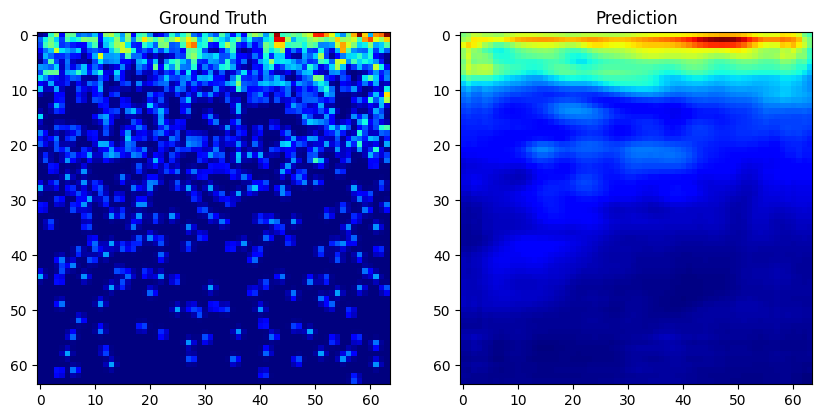

In [34]:
model.eval()
with torch.no_grad():
    imgs, dens = next(iter(val_loader))
    imgs = imgs.to(device)
    preds = model(imgs)

    gt = dens[0].cpu().numpy().squeeze()
    pr = preds[0].cpu().numpy().squeeze()

    print("GT Count:", gt.sum())
    print("Pred Count:", pr.sum())

    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    plt.imshow(gt, cmap='jet')
    plt.title("Ground Truth")

    plt.subplot(1,2,2)
    plt.imshow(pr, cmap='jet')
    plt.title("Prediction")
    plt.show()
